In [1]:
import random as rnd
rnd.seed(123)
import numpy as np
np.random.seed(123)
import tensorflow as tf
tf.random.set_seed(1234)

from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten
from keras.layers import Embedding
from keras.datasets import imdb
import matplotlib.pyplot as plt




#Allocation of memory for the GPU process
gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_virtual_device_configuration(gpus[0],
      [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=6000)])
logical = tf.config.experimental.list_logical_devices('GPU')
print(logical[0])

Using TensorFlow backend.


LogicalDevice(name='/device:GPU:0', device_type='GPU')


In [2]:
# Embedding
max_features = 20000
maxlen = 100
embedding_size = 64

# Training
batch_size = 32
epochs = 8 #modify as required, should be even

print('Loading data...')
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)

#Data Split
val_split_start = 20000
x_val = x_train[val_split_start:]
y_val = y_train[val_split_start:]
x_train = x_train[0:val_split_start]
y_train = y_train[0:val_split_start]


print(len(x_train), 'train sequences')
print(len(x_val), 'validation sequences')
print(len(x_test), 'test sequences')


print('Pad sequences (samples x time)')
x_train = sequence.pad_sequences(x_train, maxlen=maxlen)
x_val = sequence.pad_sequences(x_val, maxlen=maxlen)
x_test = sequence.pad_sequences(x_test, maxlen=maxlen)

Loading data...
20000 train sequences
5000 validation sequences
25000 test sequences
Pad sequences (samples x time)


In [3]:
print('Build models...')

class Network(Sequential):
  def __init__(self):
    super().__init__()
    self.add(Embedding(max_features, embedding_size, input_length=maxlen))
    self.add(Dense(128))
    self.add(Activation('relu'))
    self.add(Dense(128))
    self.add(Activation('relu'))
    self.add(Dense(64))
    self.add(Activation('relu'))
    self.add(Flatten())
    self.add(Dense(1))
    self.add(Activation('sigmoid'))

#Default for starting weights
model = Network()
print(model.summary())
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
model_benchmark = Network()
model_small_set = Network()
model_iterative_training = Network()


#Benchmark
model_benchmark.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
model_benchmark.set_weights(model.get_weights())


print('Train Benchmark')
history_bench = model_benchmark.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          validation_data=(x_val, y_val),verbose=2)
score, acc = model.evaluate(x_test, y_test, batch_size=batch_size)
print('Benchmark test score:', score)
print('Benchmark test accuracy:', acc)
model_benchmark.save('DenseMdl_Bench1.h5')

#Smaller data sets for semi-supervised training
small_set_limit = 2000
x_train1 = x_train[0:small_set_limit]
y_train1 = y_train[0:small_set_limit]
x_train2 = x_train[small_set_limit:20000]

#Smaller training set
print('Train on smaller set')
model_small_set.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
model_small_set.set_weights(model.get_weights())


history_small = model_small_set.fit(x_train1, y_train1,
          batch_size=batch_size,
          epochs=epochs,
          validation_data=(x_val, y_val), verbose=2)
score, acc = model_small_set.evaluate(x_test, y_test, batch_size=batch_size)
print('Small model test score:', score)
print('Small model test accuracy:', acc)
model_small_set.save('DenseMdl_Small1.h5')


#Iterative_train
print('Train iter model')
model_iterative_training.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
model_iterative_training.set_weights(model.get_weights())

history_iter1 = model_iterative_training.fit(x_train1, y_train1,
          batch_size=batch_size,
          epochs=int(epochs/2-1),
          validation_data=(x_val, y_val), verbose=2)

a = model_iterative_training.predict(x_train2)

i = 0
k = np.array([1])
j = np.array([0])

for x in np.nditer(a):
     if x>=0.9:
        x_train1 = np.append(x_train1, np.array([x_train2[i]]), axis=0)
        y_train1 = np.append(y_train1, k)
        i += 1
     elif x<=0.1:
        x_train1 = np.append(x_train1, np.array([x_train2[i]]), axis=0)
        y_train1 = np.append(y_train1, j)
        i += 1
     else:
        i += 1


history_iter2 = model_iterative_training.fit(x_train1, y_train1,
          batch_size=batch_size,
          epochs=int(epochs/2+1),
          validation_data=(x_val, y_val), verbose=2)

score, acc = model_iterative_training.evaluate(x_test, y_test, batch_size=batch_size, verbose=2)
print('Iterative test score:', score)
print('Iterative test accuracy:', acc)
model_iterative_training.save('DenseMdl_iter1.h5')

Build models...
Model: "network_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 64)           1280000   
_________________________________________________________________
dense_1 (Dense)              (None, 100, 128)          8320      
_________________________________________________________________
activation_1 (Activation)    (None, 100, 128)          0         
_________________________________________________________________
dense_2 (Dense)              (None, 100, 128)          16512     
_________________________________________________________________
activation_2 (Activation)    (None, 100, 128)          0         
_________________________________________________________________
dense_3 (Dense)              (None, 100, 64)           8256      
_________________________________________________________________
activation_3 (Activation)    (None, 100, 

/usr/local/lib/python3.8/dist-packages/tensorflow/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(


Train on 20000 samples, validate on 5000 samples
Epoch 1/8
 - 3s - loss: 0.4520 - accuracy: 0.7634 - val_loss: 0.3417 - val_accuracy: 0.8494
Epoch 2/8
 - 2s - loss: 0.2265 - accuracy: 0.9104 - val_loss: 0.3647 - val_accuracy: 0.8484
Epoch 3/8
 - 2s - loss: 0.1381 - accuracy: 0.9487 - val_loss: 0.4818 - val_accuracy: 0.8368
Epoch 4/8
 - 2s - loss: 0.0833 - accuracy: 0.9693 - val_loss: 0.6681 - val_accuracy: 0.8292
Epoch 5/8
 - 2s - loss: 0.0421 - accuracy: 0.9854 - val_loss: 0.9307 - val_accuracy: 0.8212
Epoch 6/8
 - 2s - loss: 0.0211 - accuracy: 0.9936 - val_loss: 1.3015 - val_accuracy: 0.8164
Epoch 7/8
 - 2s - loss: 0.0253 - accuracy: 0.9908 - val_loss: 1.4390 - val_accuracy: 0.8140
Epoch 8/8
 - 2s - loss: 0.0177 - accuracy: 0.9931 - val_loss: 1.6778 - val_accuracy: 0.8084
25000/25000 [==============================] - 1s 36us/step
Benchmark test score: 0.6931681077003479
Benchmark test accuracy: 0.498879998922348
Train on smaller set
Train on 2000 samples, validate on 5000 samples
Ep

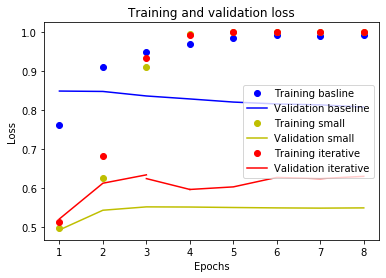

In [4]:
bench_dict = history_bench.history
small_dict = history_small.history
iter1_dict = history_iter1.history
iter2_dict = history_iter2.history
epochs_ar = range(1, epochs+1)
plt.plot(epochs_ar, bench_dict['accuracy'], 'bo', label='Training basline')
plt.plot(epochs_ar, bench_dict['val_accuracy'], 'b', label='Validation baseline')
plt.plot(epochs_ar, small_dict['accuracy'], 'yo', label='Training small')
plt.plot(epochs_ar, small_dict['val_accuracy'], 'y', label='Validation small')
plt.plot(range(1, 4), iter1_dict['accuracy'], 'ro', label='Training iterative')
plt.plot(range(1, 4), iter1_dict['val_accuracy'], 'r', label='Validation iterative')
plt.plot(range(4, 9), iter2_dict['accuracy'], 'ro')
plt.plot(range(4, 9), iter2_dict['val_accuracy'], 'r')
_ = [iter2_dict['val_accuracy'][3], iter2_dict['val_accuracy'][0]]
plt.plot(range(3, 5), _, 'r')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()